In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sim_functions import *

from tqdm import tqdm

from scipy.optimize import curve_fit

Using cupy


In [11]:
nx = 1000
ny = 500
steps = 10000
output_stride = 500
profile_interval = 500

In [12]:
molecular_weights = np.array([1,80, 17, 8]) # H2, TMIn, PH3, CH4
n_species = len(molecular_weights)
multiplier = 4.43
'''
Bss = multiplier * 1/np.sqrt(1/molecular_weights[0] + 1/molecular_weights[1])
D_lbm = 1/Bss
print('Predict diffusion constant = ', D_lbm)
'''
phi_1 = 0.78
phis = phi_1 * molecular_weights[0]/molecular_weights
print(phis)

predict_lambda = (phi_1 /3) * multiplier * 1/np.sqrt(1/molecular_weights[0] + 1/molecular_weights[0])
relaxation = predict_lambda/(1+predict_lambda/2)
viscosity_kinematic = 1/3 * (1/relaxation - 0.5)
print('viscosity_kinematic = ',viscosity_kinematic)

[0.78       0.00975    0.04588235 0.0975    ]
viscosity_kinematic =  0.40927636811167895


In [13]:
D_s = 1/(multiplier * 1/np.sqrt(1/molecular_weights[0] + 1/molecular_weights))
print('D_s = ',D_s)

D_s =  [0.31923557 0.22714009 0.23227799 0.23942668]


In [14]:
vx = 0.003
v_top = xp.array([vx, 0])
c_top = xp.array([0.979, 0.0047, 2.04, 1e-4])
absorption_ratio = xp.array([0,1,1,-3])
print(3*c_top)

[2.937e+00 1.410e-02 6.120e+00 3.000e-04]


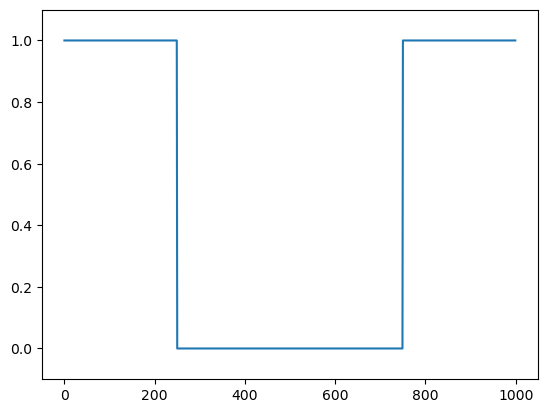

In [15]:
absorption_coefficient = 30

non_absorb_mask = xp.zeros(nx)
#non_absorb_mask[:nx//2] = True
non_absorb_mask[:] = True
non_absorb_mask[nx//4:-nx//4] = False
plt.plot(to_numpy(non_absorb_mask))
plt.ylim([-0.1, 1.1])

comp2_bc = xp.array([absorption_coefficient, 1, 0])

In [16]:
lbm_config = lbm_parameters(
    nx=nx,
    ny=ny,
    steps=steps,
    output_interval=output_stride,
    molecular_weights=xp.array(molecular_weights),
    multiplier=multiplier,
    phis=xp.array(phis),
    D_s=xp.array(D_s),
    v_top = v_top, # vx, vy
    c_top = c_top, # partial pressure
    non_absorb_mask=xp.array(non_absorb_mask),
    comp2_bc =comp2_bc,
    absorption_ratio = xp.array(absorption_ratio),
)

In [17]:
vx_ini = vx
total_pressure = 1
partial_pressure = c_top

y_coord = xp.arange(ny)
velocity_profile = vx_ini * y_coord/ny

ux_s = xp.ones((n_species, nx, ny), dtype=xp.float32) * velocity_profile[None, None, :]
uy_s = xp.zeros((n_species, nx, ny), dtype=xp.float32)

rho_s = xp.zeros((n_species, nx,ny))
for s in range(n_species):
    rho_s[s,:,:] = 3* partial_pressure[s] * xp.ones((nx,ny))

f = xp.zeros((n_species, 9, nx, ny), dtype=DTYPE)
feq = equilibrium(f, rho_s, lbm_config, ux_s, uy_s)
f = feq

f_cross_ini = feq[:, :, nx//2, :]

In [18]:
def main(f, lbm_config):
    velocity_field = []
    clip_history = []
    f_cross = []
    for step in tqdm(range(lbm_config.steps + 1)):
        if step % output_stride == 0:
            rho_s, ux_s, uy_s, rho_mix, p_mix = calculate_moment(f, lbm_config)
            ux_s = to_numpy(ux_s).astype(np.float32)
            uy_s = to_numpy(uy_s).astype(np.float32)
            velocity_field.append((ux_s, uy_s))
            #plot_vector(to_numpy(ux_s[0]), to_numpy(uy_s[0]), step, zoom = 1/vx/15, skip = nx//30, save = True)
            save_concentration_frames(f, step, lbm_config)
            #plt.plot(to_numpy(rho_s[1, :, 0]))
            #plt.show()


        f, clipped = bgk_step(f, lbm_config, top_moving_left_intake_bottom_absorb_4_species)

        clip_history.append(clipped)
        if step % profile_interval == 0:
            f_cross.append(f[1, :, nx//2, :])

        if step == steps:
            break

    return np.array(velocity_field), np.array(clip_history), to_numpy(xp.array(f_cross)), to_numpy(f)

In [ ]:
velocity_field,clip_history, f_cross, f_end = main(f, lbm_config)

  1%|          | 108/10001 [00:04<05:41, 28.96it/s]

(4, 9, 100, 40)
(4, 100, 40)
53.462971776159705


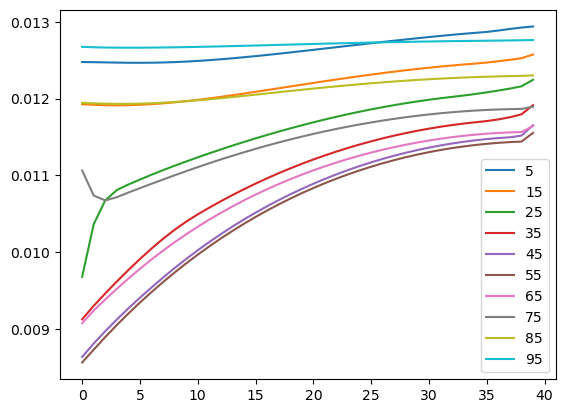

In [11]:
print(f_end.shape)
rho_s = xp.sum(f_end, axis = 1, dtype = DTYPE)
print(rho_s.shape)
for i in range(10):
    plt.plot(rho_s[1, i*(nx//10)+nx//20, :], label = f'{i*(nx//10)+nx//20}')
plt.legend()

slope = (rho_s[1, nx//2, 5]-rho_s[1, nx//2, 0])/5
b1_measured = rho_s[1, 50, 0]/slope
print(b1_measured)

In [12]:
slope2 = (rho_s[1, nx//2, 5]-rho_s[1, nx//2, 0])/5
flux2 = slope2 * D_s[1]
print(flux2)
slope3 = (rho_s[2, nx//2, 5]-rho_s[2, nx//2, 0])/5
flux3 = slope2 * D_s[2]
print(flux3)

3.618187757660642e-05
3.700031110935849e-05


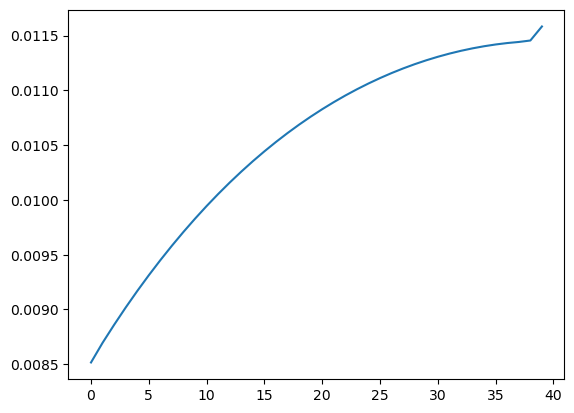

In [13]:
plt.plot(rho_s[1, 50, :])

(21, 2, 4, 100, 40)
(21, 40)


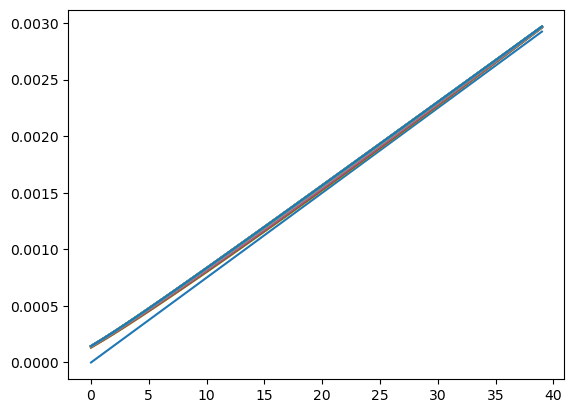

In [14]:
print(velocity_field.shape)
# frames, components, species, nx, ny

vx_profile = velocity_field[:, 0, 0, nx//2, :]
print(vx_profile.shape)
for i in range(vx_profile.shape[0]):
    plt.plot(vx_profile[i, :])

(21, 9, 40)
(20,)


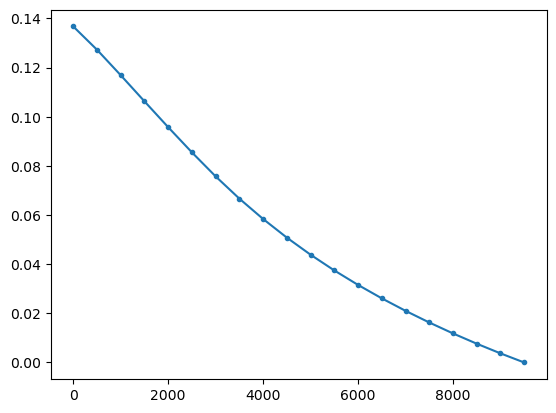

In [15]:
err = []
print(f_cross.shape)
for i in range(f_cross.shape[0]-1):
    error = np.sum(np.abs(f_cross[-i-1] - f_cross[-1]))
    err.append(error)
err = np.array(err)
print(err.shape)
plt.plot(np.arange(len(err))*profile_interval, err[::-1], marker = ".")

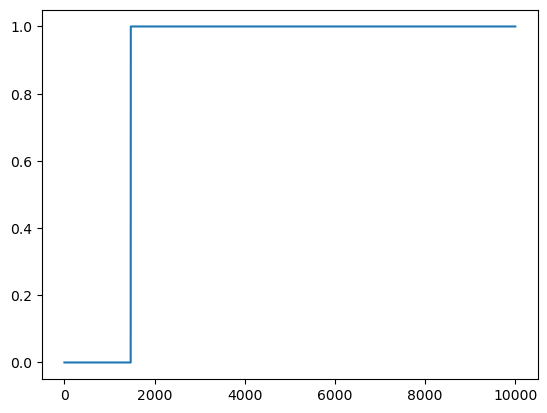

In [16]:
plt.plot(clip_history)